# Alzheimer prediction using PET signals

**Deadline**: Upload the answers and the code to the site pédagogique before the 13th of
March 2019 (23h59).

We will use the same dataset as in the second TP which is composed of PET signals averaged over a set of 69 ROIs (Region of Interest) from 60 subjects, half controls and half with Alzheimer’s disease. Data comes from the ADNI
database (http://adni.loni.usc.edu/) and has been pre-processed by the Clinica team using the procedure explained here: http://www.clinica.run/doc/Pipelines/PET_Volume/.

Please load the data from the file: ’Data_ADNI.npz’ where *X* is a matrix containing the averaged PET signals (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *labels* contains the name of the ROI of each feature.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

import numpy as np

Working_directory="" 
with np.load(Working_directory +'Data_ADNI.npz') as data:
    X = data['X'] # original landmarks   
    y = data['y'] # landmarks after GPA    
    labels = data['labels']    
    
labels=labels.tolist()
for i in range(0,len(labels)):    
    labels[i]=''.join(labels[i])
    
N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))

Number of controls and Alzheimer patients is respectively: 30 and 30


Using the library nilearn we can also show the atlas used to define the ROIs:

C:\Users\User\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


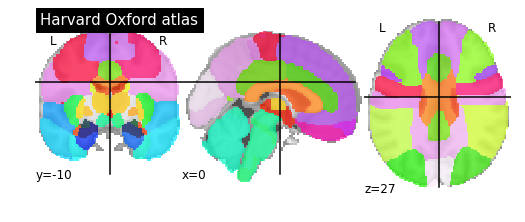

In [3]:
from nilearn import plotting
plotting.plot_roi(Working_directory + 'atlas.nii', title="Harvard Oxford atlas")
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to scale the features so that each one of them will have average equal to 0 and unit variance and create a training and test set.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size = 0.33)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Fitting Decision Trees
Tree = DecisionTreeClassifier()
Tree.fit(X_train, y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train, y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test, y_test)) )

Score in the training set is 1.0
Score in the test set is 0.8


###### We can also use the *graphviz* library to plot the decision tree. Please install it using *conda install python-graphviz*. 

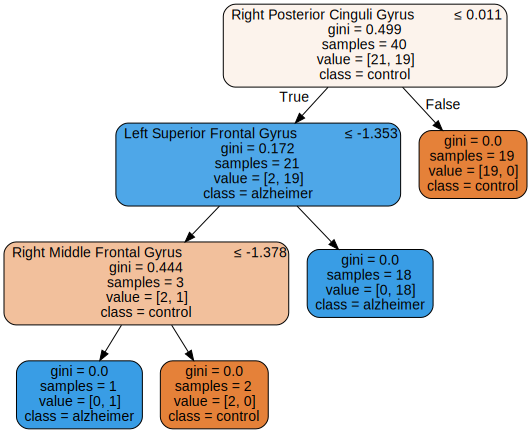

In [13]:
from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

First, divide the data into training and test and then plot the training and test test score for different values of 'min_samples_split' and 'min_samples_leaf'. What is the best value ? What happens if you split differently your data ?

In [14]:
import matplotlib.pyplot as plt

split_range = np.linspace(0.001, 0.5, 40)
leaf_range = np.linspace(0.001, 0.5, 40)

max_split = 0
max_leaf = 0
max_score = 0

for split in split_range:
    for leaf in leaf_range:
        Tree_tmp = DecisionTreeClassifier(min_samples_split=split, min_samples_leaf=leaf)
        Tree_tmp.fit(X_train, y_train)
        score_tmp = Tree_tmp.score(X_test, y_test)
        if (score_tmp > max_score):
            max_score = score_tmp
            max_split = split
            max_leaf = leaf
            
print('The best parameters obtained are: \n' +
      '- min_samples_split: {}'.format(max_split) + '\n' +
      '- min_samples_leaf: {}'.format(max_leaf) + '\n\n' +
      'The score obtained on the test set is: {}'.format(max_score))

The best parameters obtained are: 
- min_samples_split: 0.001
- min_samples_leaf: 0.07776923076923077

The score obtained on the test set is: 0.9


Now let split our data differently.

In [15]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scale, y, test_size = 0.33)

max_split = 0
max_leaf = 0
max_score = 0

for split in split_range:
    for leaf in leaf_range:
        Tree_tmp = DecisionTreeClassifier(min_samples_split=split, min_samples_leaf=leaf)
        Tree_tmp.fit(X_train2,y_train2)
        # Score in the training set
        #print('Score in the training set is {0}'.format(Tree_tmp.score(X_train,y_train)) )
        # Score in the test set
        #print('Score in the test set is {0}'.format(Tree_tmp.score(X_test,y_test)) )
        score_tmp = Tree_tmp.score(X_test2,y_test2)
        if (score_tmp > max_score):
            max_score = score_tmp
            max_split = split
            max_leaf = leaf
            
print('The best parameters obtained are: \n' +
      '- min_samples_split: {}'.format(max_split) + '\n' +
      '- min_samples_leaf: {}'.format(max_leaf) + '\n\n' +
      'The score obtained on the test set is: {}'.format(max_score))

The best parameters obtained are: 
- min_samples_split: 0.001
- min_samples_leaf: 0.11615384615384615

The score obtained on the test set is: 0.85


We remark that the parameters and the score obtained are different from the previous split.

Try to add Gaussian noise to the data (using for instance zero mean and 1 or 2 for the std) and, using the best hyperparameters found before, look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)*

In [16]:
scores = []

nb_iterations = np.arange(10)
X_noise = np.zeros(X_scale.shape)

for i in nb_iterations:

    noise_features = np.random.randn(X_scale.shape[0], X_scale.shape[1])
    X_noise = np.zeros(X_scale.shape)
    
    tmp_mean = noise_features.mean(axis = 0)
    tmp_std = noise_features.std(axis = 0)
    for k in range(noise_features.shape[1]):
        noise_features[:, k] -= tmp_mean[k]
        noise_features[:, k] /= tmp_std[k]
    
    X_noise = X_scale + noise_features
    X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_scale, y, test_size = 0.33, random_state = 0)
    
    clf_noise = DecisionTreeClassifier(min_samples_split=max_split, min_samples_leaf=max_leaf)
    clf_noise.fit(X_train_noise, y_train_noise)

    scores.append(clf_noise.score(X_test_noise, y_test_noise))

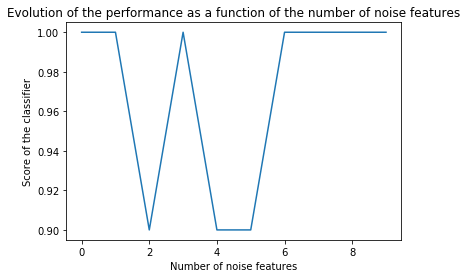

In [17]:
plt.figure()
plt.xlabel('Number of noise features')
plt.ylabel('Score of the classifier')
plt.title('Evolution of the performance as a function of the number of noise features')
plt.plot(nb_iterations, scores)
plt.show()

We see that the results are not stable, the decision tree classifier is not robust to the noise.

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values in an automatic way. Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV

p_grid_DecisionTree = {'min_samples_split': list(split_range),
                       'min_samples_leaf': list(leaf_range)}
Tree_opt = DecisionTreeClassifier()

# Looking for the best hyperparameters
grid_DecisionTree = GridSearchCV(estimator = Tree_opt, param_grid = p_grid_DecisionTree, scoring = "accuracy", cv = 5)
grid_DecisionTree.fit(X_train, y_train)
print("Best training Score: {}".format(grid_DecisionTree.best_score_))
print("Best training params: {}".format(grid_DecisionTree.best_params_))
print("Before, we found the parameters : {min_samples_leaf: " + str(max_leaf) + ", min_samples_split: " + str(max_split) + "}")

Best training Score: 0.95
Best training params: {'min_samples_leaf': 0.05217948717948718, 'min_samples_split': 0.2313076923076923}
Before, we found the parameters : {min_samples_leaf: 0.11615384615384615, min_samples_split: 0.001}


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Then, the parameters obtained are not the same as before.

Using the optimal hyperparameters, plot again the decision tree using the *graphviz* library. Is it the same ? Or similar ? 

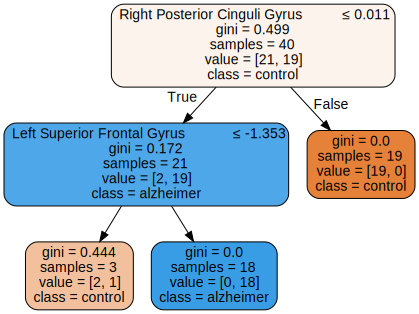

In [19]:
Tree = DecisionTreeClassifier(min_samples_leaf=grid_DecisionTree.best_params_['min_samples_leaf'],
                              min_samples_split=grid_DecisionTree.best_params_['min_samples_split'])
Tree.fit(X_train, y_train)

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

It is not the same decision tree.

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

In [20]:
from sklearn.ensemble import BaggingClassifier

best_params=grid_DecisionTree.best_params_

X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.25, random_state=0)
Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train, y_train)
print("Best Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score :",grid_bagging.score(X_test,y_test))

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Best Score: 0.8444444444444444
Best params: {'n_estimators': 15}
Bagging score : 0.9333333333333333


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise, np.ravel(y), test_size=0.25, random_state=0)
Tree_noise = DecisionTreeClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag_noise=BaggingClassifier(base_estimator=Tree_noise, random_state=0)
grid_bagging_noise = GridSearchCV(estimator=bag_noise, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging_noise.fit(X_train_noise, y_train_noise)
print("Best Score: {}".format(grid_bagging_noise.best_score_))
print("Best params: {}".format(grid_bagging_noise.best_params_))
print("Bagging score :",grid_bagging_noise.score(X_test_noise,y_test_noise))

Best Score: 0.7333333333333333
Best params: {'n_estimators': 15}
Bagging score : 0.8


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


With bagging, it is a little bit more robust but not that much because we do not have that much data. This is why there are still some differences.

The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation.

In [22]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.8444444444444444
Best params: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 10}


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 1 representing Left Hippocampus                       (0.195544)
2. feature 28 representing Right Posterior Cinguli Gyrus          (0.189389)
3. feature 59 representing Left Superior Frontal Gyrus            (0.109566)
4. feature 60 representing Right Superior Frontal Gyrus           (0.091393)
5. feature 8 representing Right Anterior Lateral Temporal Lobe   (0.089977)
6. feature 15 representing Left Fusiform Gyrus                    (0.072454)
7. feature 14 representing Right Inferior Middle Temporal Gyri    (0.054989)
8. feature 25 representing Left Anterior Cinguli Gyrus            (0.036235)
9. feature 2 representing Right Hippocampus                      (0.035372)
10. feature 26 representing Right Anterior Cinguli Gyrus           (0.034974)


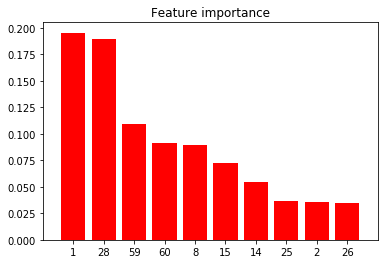

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.25, random_state=5)
best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Which are the most important features (i.e. ROIs) ?  Is there a strange feature among the first ones... Does it make sense to you to use it ? Look at the original data *X*. We have scaled it without even looking at it... maybe we should have not used all features or maybe features were already scaled.. what would you do ?

The most important features are located in the Hippocampus, the Cinguli Gyrus and the Lateral Temporal Lobe. It makes sense because we said in the second TP that Hippocampus and Lateral Temporal Lobe were highly correlated with Alzheimer disease. It appears that Cinguli Gyrus is important too. There is not a strange feature among the first ones.

We can also plot the data using only pair of the most important features.

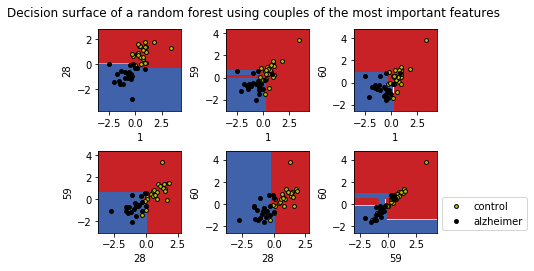

In [24]:
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "yk"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()